# Reviews Sentiment Classification and Hyperparameter Tuning





In [ ]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 


from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import numpy as np

#from sklearn.externals import joblib
import joblib


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.7/dist-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


## Mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/My\ Drive/DS200Labs

baby.csv				  IMDB5000movies.csv
BCdecisionTree.pdf			  IMDBReviewsSentiment.csv
Ben-NE-9-10-2015-pass-6.csv		  IRIS.csv
breast-cancer-wisconsin-data-windCSV.csv  player_data.csv
BreatCancerFinal.csv			  salary_data.csv
DecisionTree.pdf			  SFSalaries2011_2014.csv
faithful.csv


## Examining Data

load the csv file IMDBReviewsSentiment.csv from the directory of your Google Drive.

In [ ]:
path= "/content/drive/My Drive/DS200Labs/IMDBReviewsSentiment.csv"
reviews = Table.read_table(path)
reviews.show(10)

review,sentiment
One of the other reviewers has mentioned that after watc ...,positive
A wonderful little production. The filming t ...,positive
I thought this was a wonderful way to spend time on a to ...,positive
Basically there's a family where a little boy (Jake) thi ...,negative
"Petter Mattei's ""Love in the Time of Money"" is a visuall ...",positive
"Probably my all-time favorite movie, a story of selfless ...",positive
I sure would like to see a resurrection of a up dated Se ...,positive
"This show was an amazing, fresh & innovative idea in the ...",negative
Encouraged by the positive comments about this film on h ...,negative
If you like original gut wrenching laughter you will lik ...,positive


## Sampling Positive Data

Sample 1000 positive reviwes for constructing your predictive model for movie review sentiment analysis.

In [ ]:
pos_reviews = reviews.where("sentiment", are.equal_to('positive')).sample(1000, with_replacement = False)
pos_reviews.show(10)

review,sentiment
"Carly Jones (Elisha Curtberth), her bad boy brother Nick ...",positive
Burlinson and Thornton give an outstanding performance i ...,positive
Shameless Screen Entertainment is a relatively new and B ...,positive
"Well, it's yet again a film that plays with your sentime ...",positive
"Here's my first David Mamet directed film. Fitting, sinc ...",positive
A young Korean artist lives in Amsterdam. She is a bit o ...,positive
"Previously, I wrote that I loved ""Titanic"", cried at its ...",positive
The first 50 minutes of this movie were quite boring. It ...,positive
if you are like me then you will love this great coming ...,positive
"Sweet and charming, funny and poignant, plot less but me ...",positive


# Add a Classification Column for Positive Reviews

In [ ]:
pos_reviews2 = pos_reviews.with_column("classification", 1)
pos_reviews2.show(5)

review,sentiment,classification
"Carly Jones (Elisha Curtberth), her bad boy brother Nick ...",positive,1
Burlinson and Thornton give an outstanding performance i ...,positive,1
Shameless Screen Entertainment is a relatively new and B ...,positive,1
"Well, it's yet again a film that plays with your sentime ...",positive,1
"Here's my first David Mamet directed film. Fitting, sinc ...",positive,1


# Sampling Negative Data

sample 1000 negative reviews.

In [ ]:
neg_reviews = reviews.where("sentiment", are.equal_to('negative')).sample(1000, with_replacement=False)
neg_reviews.show(10)

review,sentiment
Much has been made of Rohmer's use of digital technology ...,negative
"Sure, it had some of the makings of a good film. The sto ...",negative
This typically melodramatic Bollywood film has inexplica ...,negative
I don't know if this type of movie was as cliché then as ...,negative
The title creatures wreak havoc at a peaceful little des ...,negative
First of all let us discuss about the story. It is a cop ...,negative
"Silly, simplistic, and short, GUN CRAZY (VOLUME 1: A WOM ...",negative
This movie appears to have been an on the job training e ...,negative
I just watched this movie with a few friends they said I ...,negative
I usually enjoy underground movies and antiheroes but th ...,negative


# Add the Classification Column for Negative Reviews

In [ ]:
neg_reviews2 = neg_reviews.with_column("classification", 0)
neg_reviews2.show(5)

review,sentiment,classification
Much has been made of Rohmer's use of digital technology ...,negative,0
"Sure, it had some of the makings of a good film. The sto ...",negative,0
This typically melodramatic Bollywood film has inexplica ...,negative,0
I don't know if this type of movie was as cliché then as ...,negative,0
The title creatures wreak havoc at a peaceful little des ...,negative,0


# Add the sampled positive reviews and the sampled negative reviews to form a labelled dataset.

This dataset will be used for creating and evaluating a Decision Tree for sentiment analysis.

In [ ]:
data = pos_reviews2.append(neg_reviews2)
data.show(5)

review,sentiment,classification
"Carly Jones (Elisha Curtberth), her bad boy brother Nick ...",positive,1
Burlinson and Thornton give an outstanding performance i ...,positive,1
Shameless Screen Entertainment is a relatively new and B ...,positive,1
"Well, it's yet again a film that plays with your sentime ...",positive,1
"Here's my first David Mamet directed film. Fitting, sinc ...",positive,1


# Data preparation for sentiment analysis

In [ ]:
# Use the data for constructing a Decision Tree Classifier for Review Sentiment
data_X= list(data['review'])
data_Y= list(data['classification'])
pos_count = data.where('classification', are.equal_to(1)).num_rows
neg_count = data.where('classification', are.equal_to(0)).num_rows

print('Data size:', len(data_X))
print('Positive Data Size: ', pos_count)
print('Negative Data Size: ', neg_count)

Data size: 2000
Positive Data Size:  1000
Negative Data Size:  1000


# Setting up stratified k-fold validation

In [ ]:
# Use Stratified Kfold Cross Validation so that
#   each fold contains the same ratio of positive/negative instances
k = 10
skf = StratifiedKFold(n_splits=k , random_state=12345, shuffle= True)

# Specify the range of max_depth for finding the best max_depth for a Decision Tree for Sentiment Classification

In [ ]:
### Set the range of max_depth for finding the best max_depth for this problem
low_max_depth = 2
high_max_depth = 10
training_performance_table = np.empty( [high_max_depth+1, k, 5] )
testing_performance_table = np.empty( [high_max_depth+1, k, 5] )

# Finding the best depth

(1) transforms the review text in the input data (of a fold) to its word frequency matrix,  
(2) use the word frequency matrix of training reviews and their corresponding sentiment classification to create a decision tree,  
(3) evaluate the decision tree created using training data (of the fold)   
(4) repeat step 1 to step 3 a total of k times (once for each fold) for each max_depth setting (from the low_max_depth you
specified to high_max_depth you specified).

In [ ]:
for depth in range(low_max_depth, high_max_depth+1):

    fold = 0

    for train_index, test_index in skf.split(data_X, data_Y):
        print("Fold Number:", fold)
     #   print("Training Data Index:", train_index)
        print("Testing Data Index:", test_index)  
    
        x_train= list(data.take(train_index)['review'])     
    #    print("Training Data:", x_train)
        y_train= list(data.take(train_index)['classification'])
    #    print("Training Data Target Output:", y_train)
        x_test= list(data.take(test_index)['review'])
    #    print("Testing Data:", x_test)
        y_test= list(data.take(test_index)['classification'])
        print("Testing Data Target Output:", y_test)
    
        count_vect = CountVectorizer(token_pattern='(?:([@#]|[0-9]|[a-z]|[A-Z])+)', analyzer= 'word', min_df=2)
        X_word_vect = count_vect.fit_transform(x_train)
    
        clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 100, max_depth=depth, \
                                  min_samples_leaf =2)
    
        clf.fit(X_word_vect, y_train)
    
        ### Use the model generated to predict for training data
        predicted_training_y = clf.predict(X_word_vect)
    
        train_p = metrics.precision_score(y_train, predicted_training_y)
        train_r = metrics.recall_score(y_train, predicted_training_y)
        train_f1= metrics.f1_score(y_train, predicted_training_y)
        training_performance_table[depth, fold, 0]=depth
        training_performance_table[depth, fold, 1]=train_p
        training_performance_table[depth, fold, 2]=train_r
        training_performance_table[depth, fold, 3]=train_f1
        print("Max depth is ", depth, "Prediction Performance for Training Data f1:", train_f1)

        ### Use the model generated to predict for testint data
        x_test_word_vect = count_vect.transform(x_test)
        predicted_testing_y = clf.predict(x_test_word_vect)
    
        test_p= metrics.precision_score(y_test, predicted_testing_y)
        test_r= metrics.recall_score(y_test, predicted_testing_y)
        test_f1 = metrics.f1_score(y_test, predicted_testing_y)
        testing_performance_table[depth, fold, 0]=depth
        testing_performance_table[depth, fold, 1]=test_p
        testing_performance_table[depth, fold, 2]= test_r
        testing_performance_table[depth, fold, 3]= test_f1
        print("Prediction Performance for Testing Data f1:", test_f1)
    
        fold=fold+1
    


Fold Number: 0
Testing Data Index: [  21   36   46   59   60   65   79  114  155  159  161  171  185  192
  204  208  217  235  240  243  245  250  256  261  273  287  289  294
  308  310  321  333  341  349  351  363  378  389  402  412  425  453
  456  470  478  501  503  517  518  519  520  525  527  528  530  536
  550  578  610  611  630  635  649  653  666  682  691  693  694  700
  706  709  718  757  766  786  790  796  804  806  813  818  847  848
  851  909  914  925  936  937  941  942  945  959  967  968  970  974
  976  983 1000 1018 1021 1025 1032 1046 1067 1075 1076 1091 1103 1104
 1140 1145 1146 1149 1152 1159 1177 1227 1242 1252 1256 1257 1258 1259
 1260 1263 1271 1289 1296 1298 1312 1331 1358 1368 1403 1423 1425 1431
 1438 1448 1455 1466 1467 1484 1501 1504 1518 1522 1526 1547 1552 1553
 1558 1572 1579 1601 1614 1616 1623 1625 1626 1639 1646 1654 1655 1658
 1671 1682 1689 1692 1698 1701 1707 1712 1714 1717 1719 1720 1722 1737
 1755 1772 1796 1811 1841 1846 1847 1854 1

### Calculate Average, Minimum, and Maximum f1 score across folds 
The first dimension of training_performance_table refers to a specific max_depth value.
The second dimension of training_performance_table refers to the number of a fold (in a k-fold).
The third dimension of training_performance_table saves f1 score in index "3".

For example, the code below returns an array of f1_score for all k folds for max_depth set to 3.

In [ ]:
f1_array=training_performance_table[3, 0:k+1:1, 3]
print(f1_array)

[0.48504983 0.46994536 0.39107005 0.66300676 0.42222222 0.49901768
 0.42813918 0.67221991 0.66723044 0.28010705]


### calculate the average performance across all folds for each max_depth so that we can compare them. 

In [ ]:
cv_training_f1_summary = np.empty( [high_max_depth+1, 3])
cv_testing_f1_summary = np.empty( [high_max_depth+1, 3])
first_fold = 0
last_fold = 5+1
for depth in range(low_max_depth, high_max_depth+1):
    train_f1_array = training_performance_table[depth, first_fold:last_fold:1 , 3]
    cv_training_f1_summary[depth, 0] = np.average(train_f1_array)
    cv_training_f1_summary[depth, 1] = np.amin(train_f1_array)
    cv_training_f1_summary[depth, 2] = np.amax(train_f1_array)
    test_f1_array = testing_performance_table[depth, first_fold:last_fold:1, 3]
    cv_testing_f1_summary[depth, 0] = np.average(test_f1_array)
    cv_testing_f1_summary[depth, 1] = np.amin(test_f1_array)
    cv_testing_f1_summary[depth, 2] = np.amax(test_f1_array)

### Plot the average of f1 scores (across all k folds) for each max_depth, and compare the average of f1 scores for training data and testing data

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [ ]:
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  """Entry point for launching an IPython kernel.


In [ ]:
depth=np.linspace(low_max_depth, high_max_depth, high_max_depth-low_max_depth+1)
print(depth)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [ ]:
avg_f1_training = cv_training_f1_summary[low_max_depth:high_max_depth+1, 0]
min_f1_training = cv_training_f1_summary[low_max_depth:high_max_depth+1, 1]
avg_f1_testing = cv_testing_f1_summary[low_max_depth:high_max_depth+1, 0]
min_f1_testing = cv_testing_f1_summary[low_max_depth:high_max_depth+1, 1]

plotting average f1 (across k folds) for training data and for plotting average f1 (across k folds) for testing data.

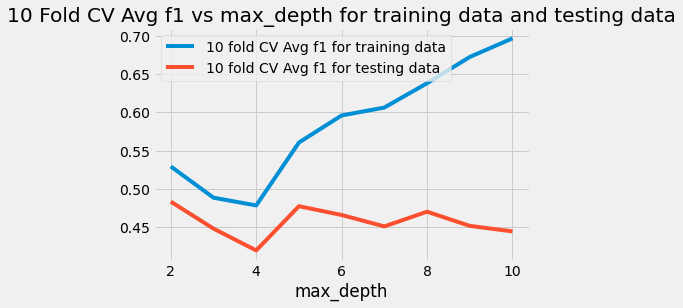

In [ ]:
training_avg_f1_label = str(k) + ' fold CV Avg f1 for training data'
testing_avg_f1_label = str(k) + ' fold CV Avg f1 for testing data'

plt.plot(depth, avg_f1_training, label= training_avg_f1_label)
plt.plot(depth, avg_f1_testing, label= testing_avg_f1_label)
plt.xlabel('max_depth')
plot_title = str(k) + " Fold CV Avg f1 vs max_depth for training data and testing data"
plt.title(plot_title)
plt.legend()
plt.show()

plotting both the average and the minimum f1 score (across k folds) for both training and testing data.

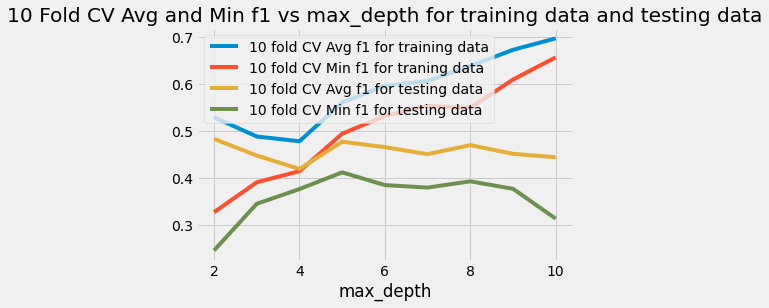

In [ ]:
training_min_f1_label = str(k) + ' fold CV Min f1 for traning data'
testing_min_f1_label = str(k) + ' fold CV Min f1 for testing data'

plt.plot(depth, avg_f1_training, label= training_avg_f1_label )
plt.plot(depth, min_f1_training, label= training_min_f1_label )
plt.plot(depth, avg_f1_testing, label= testing_avg_f1_label )
plt.plot(depth, min_f1_testing, label= testing_min_f1_label )
plt.xlabel('max_depth')
plot_title = str(k) + ' Fold CV Avg and Min f1 vs max_depth for training data and testing data'
plt.title(plot_title)
plt.legend()
plt.show()

Chose max_depth of 5 since the f1 value of avg f1 and min f1 for testing data peaks at max_depth of 5. Avg f1 for testing data might be slightly higher at 2 than 5 but min f1 value is much lower at 2 than 5 so it would be better to pick max_depth of 5. 